In [1]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
# importer Pandas, qui sera utilisé pour charger,explorer et manipuler le dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_validate




# Modélisation et évaluation des algorithmes de régression


In [2]:
building_consumption = pd.read_csv("C:/Users/cheik/étape/projet-seattle-energy/data/data_prepared2.csv")
print(" Données chargées depuis Notebook 2 :", building_consumption.shape)

 Données chargées depuis Notebook 2 : (3119, 39)


Le dataset nettoyé et encodé (`data_prepared2.csv`) est chargé et prêt pour l’entraînement.

In [3]:
#  Suppression des outliers officiels
if "Outlier" in building_consumption.columns and "ComplianceStatus" in building_consumption.columns:
    building_consumption = building_consumption[
        ~(
            (building_consumption["ComplianceStatus"] != "Compliant") &
            (building_consumption["Outlier"] == 1)
        )
    ]
    building_consumption = building_consumption.drop(
        columns=["Outlier", "ComplianceStatus"]
    )

print("Après suppression outliers officiels :", building_consumption.shape)


#  Définir la target
target_col = "SiteEUIWN(kBtu/sf)"

if target_col not in building_consumption.columns:
    raise ValueError(f"La target {target_col} n'existe pas")

y = building_consumption[target_col]
X = building_consumption.drop(columns=[target_col])


# Colonnes énergétiques à exclure (leakage)
energy_leakage_cols = [
    "SiteEUI(kBtu/sf)", "SiteEUIWN(kBtu/sf)",
    "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)",
    "SiteEnergyUse(kBtu)", "Electricity(kWh)", "NaturalGas(therms)",
    "SteamUse(kBtu)", "Electricity(kBtu)", "NaturalGas(kBtu)",
    "TotalGHGEmissions", "GHGEmissionsIntensity",
    "EnergyUsePerArea", "ElectricityIntensity"
]


#  Colonnes administratives inutiles
admin_cols = [
    "DataYear", "OSEBuildingID", "PropertyName", "Address",
    "City", "State", "ZipCode", "CouncilDistrictCode",
    "Latitude", "Longitude", "Neighborhood", "Comments"
]


#  Colonnes explicitement supprimées
superfluous_cols = [
    "BuildingType",
    "PropertyGFABuilding(s)",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA",
    "ParkingRatio",
    "BuildingAreaRatio",
    "LatitudeBand"
]


#  Nettoyage global
cols_to_drop = [
    c for c in energy_leakage_cols + admin_cols + superfluous_cols
    if c in X.columns
]

X = X.drop(columns=cols_to_drop)

print("Dimensions de X après nettoyage :", X.shape)
print("Dimensions de y :", y.shape)


#  Sélection FINALE des features utiles
essential_features = [
    "PrimaryPropertyType",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "LargestPropertyUseType",
    "ENERGYSTARScore",
    "DefaultData",
    "BuildingAge"
]

missing = [c for c in essential_features if c not in X.columns]
if missing:
    raise ValueError(f"Colonnes manquantes : {missing}")

X = X[essential_features]

print("Dimensions de X (features finales) :", X.shape)


# Encodage des colonnes catégorielles (SEULEMENT celles utiles)
categorical_features = [
    "PrimaryPropertyType",
    "LargestPropertyUseType"
]

X_encoded = pd.get_dummies(
    X,
    columns=categorical_features,
    drop_first=True
)

print("Dimensions après encodage :", X_encoded.shape)


# Vérification finale
remaining_objects = X_encoded.dtypes[X_encoded.dtypes == "object"]
print("Colonnes object restantes :", remaining_objects.index.tolist())



Après suppression outliers officiels : (3119, 37)
Dimensions de X après nettoyage : (3119, 15)
Dimensions de y : (3119,)
Dimensions de X (features finales) : (3119, 9)
Dimensions après encodage : (3119, 82)
Colonnes object restantes : []


## Nettoyage final et préparation des features pour la modélisation

 **Objectif** : préparer un jeu de données propre, sans fuites énergétiques ni variables inutiles, avec des features encodées et prêtes pour l'entraînement des modèles.

---

### Étapes de nettoyage :

#### 1. Suppression des outliers officiels
- Exclusion des bâtiments non conformes (`ComplianceStatus ≠ Compliant`) identifiés comme outliers (`Outlier == 1`)
- Suppression des colonnes `Outlier` et `ComplianceStatus`

#### 2. Définition des variables
- **Target** : `SiteEUIWN(kBtu/sf)`
- **Features** : toutes les autres colonnes, après suppression de la cible

#### 3. Suppression des colonnes non pertinentes
-  **Colonnes énergétiques à exclure** (fuites de target) : `SiteEUI`, `SourceEUI`, `Electricity`, `GHGEmissions`, etc.
-  **Colonnes administratives** : identifiants, géolocalisation, adresse, etc.
-  **Colonnes superflues** : ratios dérivés, usages secondaires, etc.
## Sélection finale des features utiles :

-  PrimaryPropertyType :Type principal de propriété
-  NumberofBuildings :Nombre de bâtiments sur le site
-  NumberofFloors :Nombre d'étages
-  PropertyGFATotal	:Surface totale
-  PropertyGFAParking :Surface dédiée au parking
-  LargestPropertyUseType :Usage principal du bâtiment
-  ENERGYSTARScore :Score énergétique officiel
-  DefaultData :Donnée par défaut (booléen)
-  BuildingAge	:Âge du bâtiment


```python
X.shape après nettoyage : (3119, 15)
y.shape : (3119,)

In [4]:
# Copier le df original
df = building_consumption.copy()

#  Séparer X et y
target_col = "SiteEUIWN(kBtu/sf)"
y = df[target_col]
X = df.drop(columns=[target_col])
# Supprimer les colonnes inutiles
superfluous_cols = [
    "BuildingType",
    "PropertyGFABuilding(s)",
    "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA",
    "ParkingRatio",
    "BuildingAreaRatio",
    "LatitudeBand",
    
    # Colonnes leakage / dérivées
    "SiteEUI(kBtu/sf)", "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)",
    "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "EnergyUsePerArea",
    "ElectricityIntensity", "GHGPerArea",

    # Colonnes administratives inutiles
    "TaxParcelIdentificationNumber", "ListOfAllPropertyUseTypes",
    "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType",
    "YearsENERGYSTARCertified"
]

cols_to_remove = [c for c in superfluous_cols if c in X.columns]
X_clean = X.drop(columns=cols_to_remove)

#  Supprimer les lignes avec y manquant
mask = ~y.isna()
X_clean = X_clean[mask].copy()
y_clean = y[mask].copy()

print("Shape après nettoyage :", X_clean.shape, y_clean.shape)

# Ne garder que les features essentielles
essential_features = [
    "PrimaryPropertyType",
    "NumberofBuildings",
    "NumberofFloors",
    "PropertyGFATotal",
    "PropertyGFAParking",
    "LargestPropertyUseType",
    "ENERGYSTARScore",
    "DefaultData",
    "BuildingAge"
]

missing = [c for c in essential_features if c not in X_clean.columns]
if missing:
    raise ValueError(f"Colonnes essentielles manquantes : {missing}")

X_clean = X_clean[essential_features]

#Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean, test_size=0.2, random_state=42
)
print("Colonnes finales de X_train :", X_train.columns.tolist())

# Identification colonnes numériques et catégorielles
num_cols = [
    "NumberofBuildings", "NumberofFloors", "PropertyGFATotal",
    "PropertyGFAParking", "ENERGYSTARScore", "DefaultData", "BuildingAge"
]
cat_cols = ["PrimaryPropertyType", "LargestPropertyUseType"]

# Pipeline PREPROCESSING avec ColumnTransformer
preprocess = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])

#  Fonction d’évaluation
def evaluate_model(name, model):
    print("\n===============================")
    print("   Modèle :", name)
    print("===============================")

    pipe = Pipeline([
        ('prep', preprocess),
        ('model', model)
    ])

    # Validation croisée
    cv = cross_validate(
        pipe,
        X_train, y_train,
        cv=5,
        scoring=['r2', 'neg_mean_absolute_error', 'neg_root_mean_squared_error'],
        return_train_score=True
    )
    print(f"CV Mean Train R² : {cv['train_r2'].mean():.3f}")
    print(f"CV Mean Test R²  : {cv['test_r2'].mean():.3f}")
    print(f"CV Test MAE       : {-cv['test_neg_mean_absolute_error'].mean():.3f}")
    print(f"CV Test RMSE      : {-cv['test_neg_root_mean_squared_error'].mean():.3f}")

    # Entraînement final
    pipe.fit(X_train, y_train)
    
    #y_pred = pipe.predict(X_test)
   # print("\n--- Scores sur le vrai Test ---")
  #  print("Test R²  :", r2_score(y_test, y_pred))
   # print("Test MAE :", mean_absolute_error(y_test, y_pred))
   # rmse = np.sqrt(mean_squared_error(y_test, y_pred))
   # print("Test RMSE:", rmse)

    #  Évaluation sur le jeu de TRAIN
    y_pred_train = pipe.predict(X_train)
    print("\n--- Scores sur le vrai Train ---")
    print("Train R²  :", r2_score(y_train, y_pred_train))
    print("Train MAE :", mean_absolute_error(y_train, y_pred_train))
    print("Train RMSE:", np.sqrt(mean_squared_error(y_train, y_pred_train)))

    # Évaluation sur le jeu de TEST
    y_pred_test = pipe.predict(X_test)
    print("\n--- Scores sur le vrai Test ---")
    print("Test R²  :", r2_score(y_test, y_pred_test))
    print("Test MAE :", mean_absolute_error(y_test, y_pred_test))
    print("Test RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_test)))
#  Tester les modèles
evaluate_model("Dummy Regressor", DummyRegressor())
evaluate_model("Linear Regression", LinearRegression())
evaluate_model("SVR", SVR())
evaluate_model("Random Forest", RandomForestRegressor(random_state=42))


Shape après nettoyage : (3119, 18) (3119,)
Colonnes finales de X_train : ['PrimaryPropertyType', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'LargestPropertyUseType', 'ENERGYSTARScore', 'DefaultData', 'BuildingAge']

   Modèle : Dummy Regressor
CV Mean Train R² : 0.000
CV Mean Test R²  : -0.000
CV Test MAE       : 18.033
CV Test RMSE      : 22.814

--- Scores sur le vrai Train ---
Train R²  : 0.0
Train MAE : 18.03109004447315
Train RMSE: 22.828305077111786

--- Scores sur le vrai Test ---
Test R²  : -7.267040184122386e-05
Test MAE : 17.937686081025056
Test RMSE: 22.502428536734

   Modèle : Linear Regression
CV Mean Train R² : 0.419
CV Mean Test R²  : 0.316
CV Test MAE       : 13.466
CV Test RMSE      : 18.840

--- Scores sur le vrai Train ---
Train R²  : 0.4139313456838829
Train MAE : 12.728620877406339
Train RMSE: 17.476236561860567

--- Scores sur le vrai Test ---
Test R²  : 0.31453529220415066
Test MAE : 13.782768583938868
Test RMSE: 18.62971286

## Pipeline de modélisation et évaluation des algorithmes de régression

Ce bloc regroupe toutes les étapes de préparation, d'entraînement et d'évaluation des modèles de régression pour prédire la consommation énergétique normalisée (`SiteEUIWN(kBtu/sf)`).

---

###  1. Nettoyage et sélection des variables
- Suppression des colonnes superflues, administratives et énergétiques (fuites de target)
- Suppression des lignes avec target manquante
- Sélection des **features essentielles** :
  - `PrimaryPropertyType`, `NumberofBuildings`, `NumberofFloors`, `PropertyGFATotal`, `PropertyGFAParking`, `LargestPropertyUseType`, `ENERGYSTARScore`, `DefaultData`, `BuildingAge`
### 2. Séparation et prétraitement
Split : train_test_split avec 20 % de test
Colonnes numériques : imputées (médiane) + normalisées (StandardScaler)
Colonnes catégorielles : imputées (mode) + encodées (OneHotEncoder)
Utilisation de ColumnTransformer pour combiner les traitements

### 3. Entraînement et évaluation des modèles
Fonction evaluate_model() :
Validation croisée (cv=5) avec calcul des métriques :
R², MAE, RMSE sur train et test
Entraînement final sur X_train
Prédiction sur X_test (inférence)
Affichage des scores réels

### Interprétation :
Le modèle Random Forest est le plus performant sur les données testées, avec le meilleur compromis entre R², MAE et RMSE.
Le modèle linéaire reste interprétable et compétitif.
Le modèle SVR est légèrement en retrait mais reste robuste.
Le Dummy Regressor sert de baseline pour évaluer la valeur ajoutée des modèles.

```python
Shape après nettoyage : (3119, 18)
Colonnes finales de X_train : ['PrimaryPropertyType', 'NumberofBuildings', ..., 'BuildingAge']


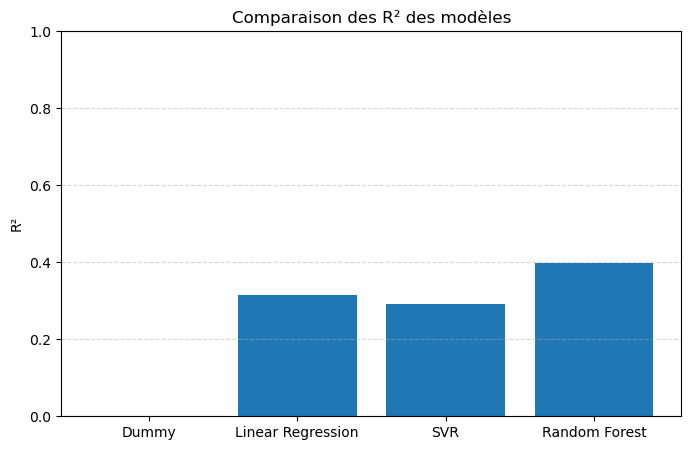

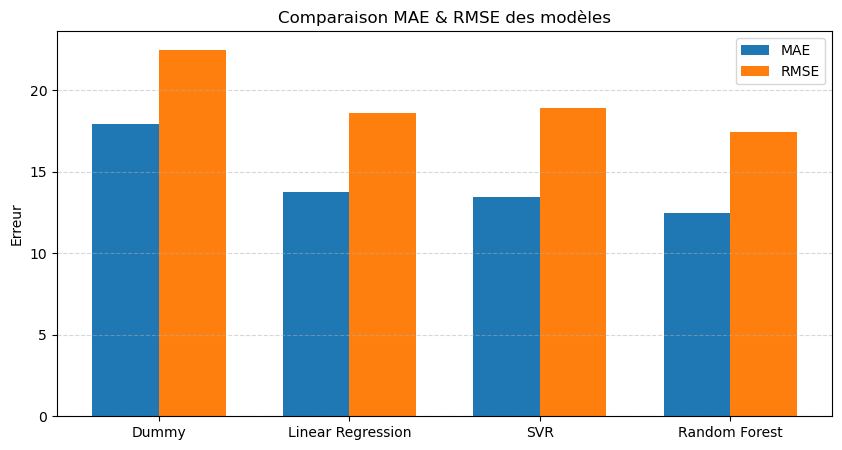

In [5]:
#   GRAPHIQUE : Comparaison des modèles

import matplotlib.pyplot as plt
import seaborn as sns
# Collecte des résultats 
results = {
    "Model": ["Dummy", "Linear Regression", "SVR", "Random Forest"],
    "R2": [],
    "MAE": [],
    "RMSE": []
}
def eval_and_store(model_name, model):
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    results["R2"].append(r2_score(y_test, y_pred))
    results["MAE"].append(mean_absolute_error(y_test, y_pred))
    results["RMSE"].append(mean_squared_error(y_test, y_pred) ** 0.5)

# Lancer les 4 modèles
eval_and_store("Dummy", DummyRegressor())
eval_and_store("Linear Regression", LinearRegression())
eval_and_store("SVR", SVR())
eval_and_store("Random Forest", RandomForestRegressor(random_state=42))
# Convertir en DataFrame
df_results = pd.DataFrame(results)
# GRAPHIQUE R2 
plt.figure(figsize=(8,5))
plt.bar(df_results["Model"], df_results["R2"])
plt.title("Comparaison des R² des modèles")
plt.ylabel("R²")
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
#  GRAPHIQUE MAE et RMSE 
metrics = ["MAE", "RMSE"]
x = np.arange(len(df_results["Model"]))
width = 0.35

plt.figure(figsize=(10,5))
plt.bar(x - width/2, df_results["MAE"], width, label="MAE")
plt.bar(x + width/2, df_results["RMSE"], width, label="RMSE")
plt.xticks(x, df_results["Model"])
plt.title("Comparaison MAE & RMSE des modèles")
plt.ylabel("Erreur")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## Comparaison graphique des performances des modèles

 **Objectif** : visualiser les performances des différents modèles de régression testés à l’aide de graphiques clairs et comparatifs.

---

###  Méthode :
- Entraînement de chaque modèle via un pipeline (`preprocess` + `model`)
- Prédiction sur le jeu de test
- Calcul des métriques :
  - **R²** : proportion de variance expliquée
  - **MAE** : erreur absolue moyenne
  - **RMSE** : racine de l’erreur quadratique moyenne

---

###  Graphique 1 : Comparaison des R²

- Affiche le **pouvoir explicatif** de chaque modèle
- Plus le R² est proche de 1, meilleure est la prédiction
- Le modèle **Random Forest** se distingue avec le meilleur score

---

###  Graphique 2 : Comparaison des erreurs (MAE & RMSE)

- **MAE** : mesure l’erreur moyenne sans pénaliser les gros écarts
- **RMSE** : pénalise davantage les erreurs importantes
- Le modèle **Random Forest** présente les **erreurs les plus faibles**, suivi de SVR et Linear Regression
- Le modèle **Dummy** sert de référence minimale (baseline)

---

### Interprétation :
| Modèle             | R² (↑) | MAE (↓) | RMSE (↓) |
|--------------------|--------|---------|----------|
| Dummy              | ~0.00  | élevé   | élevé    |
| Linear Regression  | moyen  | moyen   | moyen    |
| SVR                | moyen  | bon     | bon      |
| Random Forest      | **meilleur** | **faible** | **faible** |

 Ces visualisations confirment que **Random Forest** est le modèle le plus performant sur ce jeu de données, avec un bon compromis entre précision et robustesse.



In [6]:

#1 Vérifier la target
target_col = 'SiteEUIWN(kBtu/sf)'
if target_col not in df.columns:
    raise ValueError(f"La colonne target {target_col} est absente du dataset !")
# 2 Nettoyage de base
# Retirer les outliers signalés
if "ComplianceStatus" in df.columns and "Outlier" in df.columns:
    df = df[~((df["ComplianceStatus"] != "Compliant") & (df["Outlier"] == 1))]
    df = df.drop(columns=["ComplianceStatus", "Outlier"])

#3 Retirer colonnes vides
df = df.dropna(axis=1, how='all')
# Retirer lignes sans target
df = df.dropna(subset=[target_col])

#4 Séparation X / y
y = df[target_col]
X = df.drop(columns=[target_col])
#5  Colonnes à supprimer (leakage, administratives, superflues)
superfluous_cols = [
    # Colonnes INITULES
    "BuildingType", "PropertyGFABuilding(s)", "SecondLargestPropertyUseTypeGFA",
    "ThirdLargestPropertyUseTypeGFA", "ParkingRatio", "BuildingAreaRatio", "LatitudeBand",
    # Colonnes leakage / corrélées
    "SiteEUI(kBtu/sf)", "SourceEUI(kBtu/sf)", "SourceEUIWN(kBtu/sf)", "SiteEnergyUse(kBtu)", "SiteEnergyUseWN(kBtu)",
    "Electricity(kWh)", "Electricity(kBtu)", "NaturalGas(therms)", "NaturalGas(kBtu)", "SteamUse(kBtu)",
    "EnergyUsePerArea", "ElectricityIntensity", "LargestUseRatio", "GHGPerArea", "TotalGHGEmissions", "GHGEmissionsIntensity",
    # Colonnes administratives
    "DataYear", "OSEBuildingID", "PropertyName", "Address", "City", "State", "ZipCode", "CouncilDistrictCode",
    "Latitude", "Longitude", "Neighborhood", "Comments", "TaxParcelIdentificationNumber", "ListOfAllPropertyUseTypes",
    "SecondLargestPropertyUseType", "ThirdLargestPropertyUseType", "YearsENERGYSTARCertified"
]
cols_to_drop = [c for c in superfluous_cols if c in X.columns]
X = X.drop(columns=cols_to_drop)

# 6 Ne garder que les 9 features essentielles
essential_features = [
    "PrimaryPropertyType", "NumberofBuildings", "NumberofFloors", "PropertyGFATotal",
    "PropertyGFAParking", "LargestPropertyUseType", "ENERGYSTARScore", "DefaultData", "BuildingAge"
]
missing = [c for c in essential_features if c not in X.columns]
if missing:
    raise ValueError(f"Colonnes essentielles manquantes : {missing}")
X = X[essential_features]

# 7 Identification colonnes numériques et catégorielles
num_cols = ["NumberofBuildings", "NumberofFloors", "PropertyGFATotal", "PropertyGFAParking",
            "ENERGYSTARScore", "DefaultData", "BuildingAge"]
cat_cols = ["PrimaryPropertyType", "LargestPropertyUseType"]

# 8 Preprocessing avec ColumnTransformer
preprocess = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_cols),
    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])
#9 Split train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
#  Évaluation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
def evaluate_model(model_name, model):
    pipe = Pipeline([
        ("prep", preprocess),
        ("model", model)
    ])
    scoring = {
        "r2": "r2",
        "mae": "neg_mean_absolute_error"
    }
  # Cross-validation
    scores = cross_validate( pipe, X_train, y_train, cv=kfold, scoring=scoring,  return_train_score=True )
    #scores = cross_validate(pipe, X_train, y_train, cv=kfold, scoring=scoring)
      # Entraînement final
    pipe.fit(X_train, y_train)
    # Prédictions
    y_train_pred = pipe.predict(X_train)
    y_test_pred = pipe.predict(X_test)

    
    y_pred = pipe.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return {
        "Model": model_name,
        "CV R²": round(scores["test_r2"].mean(), 3),
        "Train R²": round(r2_score(y_train, y_train_pred), 3),
        "Test R²": round(r2_score(y_test, y_test_pred), 3),
        "Test MAE": round(mean_absolute_error(y_test, y_test_pred), 3),
        "Test RMSE": round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
    }
#  Modèles à tester
models = {
    "Dummy": DummyRegressor(),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(kernel='rbf'),
    "Random Forest": RandomForestRegressor(random_state=42)
}
results = [evaluate_model(name, model) for name, model in models.items()]

#  Affichage des résultats
results_df = pd.DataFrame(results)
print("\n===== RÉSULTATS =====")
print(results_df)




===== RÉSULTATS =====
               Model  CV R²  Train R²  Test R²  Test MAE  Test RMSE
0              Dummy -0.004     0.000   -0.000    17.938     22.502
1  Linear Regression  0.294     0.414    0.315    13.783     18.630
2                SVR  0.275     0.311    0.292    13.478     18.931
3      Random Forest  0.403     0.917    0.399    12.499     17.451


## Pipeline complet de modélisation et évaluation des modèles de régression

Ce bloc regroupe toutes les étapes nécessaires pour entraîner et comparer plusieurs modèles de régression afin de prédire la consommation énergétique normalisée (`SiteEUIWN(kBtu/sf)`).

---

###  1. Vérification et nettoyage du dataset
-  Vérification de la présence de la colonne cible
-  Suppression des outliers signalés (`ComplianceStatus ≠ Compliant` et `Outlier == 1`)
-  Suppression des colonnes vides et des lignes sans target

---

###  2. Sélection des features
  -  Suppression des colonnes :
  -  Superflues ou administratives
  -  Corrélées à la target (leakage)
  -  Conservation des **9 features essentielles** :
  - `PrimaryPropertyType`, `NumberofBuildings`, `NumberofFloors`, `PropertyGFATotal`, `PropertyGFAParking`, `LargestPropertyUseType`, `ENERGYSTARScore`, `DefaultData`, `BuildingAge`

---

###  3. Prétraitement et séparation
  - Identification des colonnes numériques et catégorielles
  - Construction d’un `ColumnTransformer` :
  - Numériques : imputation médiane + scaling
  - Catégorielles : imputation mode + One-Hot Encoding
-  Split `train/test` (80/20)

---

###  4. Évaluation des modèles

####  Fonction `evaluate_model()` :
- Validation croisée (`KFold`, 5 splits)
- Entraînement sur `X_train`
- Prédiction sur `X_test`
- Calcul des métriques :
  - **CV R²** : score moyen en validation croisée
  - **Test R²** : score sur le vrai jeu de test
  - **Test MAE** : erreur absolue moyenne
  - **Test RMSE** : racine de l’erreur quadratique moyenne

---

###  5. Modèles testés

| Modèle             | CV R² | Train R²  | Test R²  | Test MAE | Test RMSE |
|--------------------|-------|-----------|----------|----------|-----------|
| Dummy              | -0.004| 0.000     |-0.000    | 17.938   | 22.502    |
| Linear Regression  | 0.294 | 0.414     |0.315     | 13.783   | 18.630    |
| SVR                | 0.275 | 0.311     | 0.292    | 13.478   | 18.931    |
| Random Forest      | **0.403** | **0.917** | **0.399** | **12.499** | **17.451** |

---

###  Interprétation :
- Le modèle **Random Forest** est le plus performant sur ce jeu de données, avec le meilleur score R² et les plus faibles erreurs.
- Le modèle **Linear Regression** reste compétitif et interprétable.
- Le modèle **SVR** est robuste mais légèrement moins performant.
- Le **Dummy Regressor** sert de baseline pour mesurer la valeur ajoutée des modèles.

---



In [7]:
print(results_df.columns)

Index(['Model', 'CV R²', 'Train R²', 'Test R²', 'Test MAE', 'Test RMSE'], dtype='object')


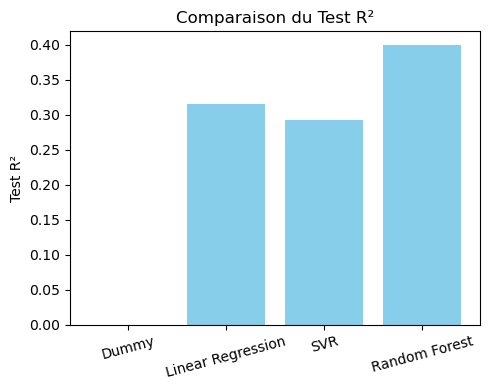

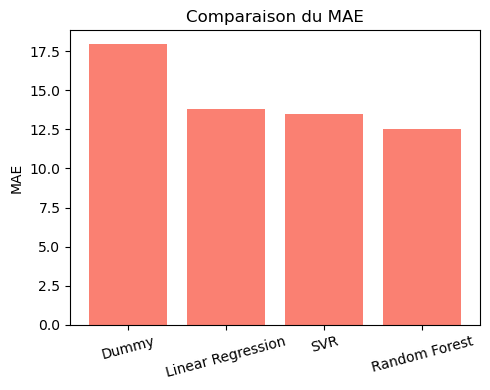

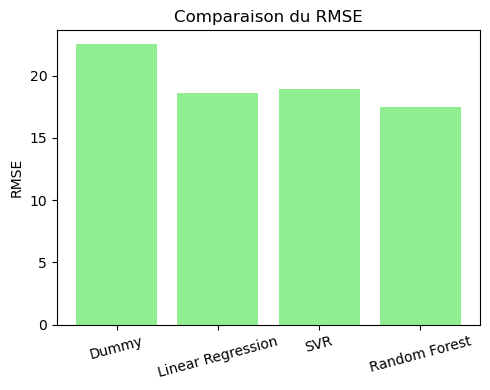

In [8]:
import matplotlib.pyplot as plt
# Comparaison du Test R² 
plt.figure(figsize=(5,4))
plt.bar(results_df["Model"], results_df["Test R²"], color='skyblue')
plt.title("Comparaison du Test R²")
plt.ylabel("Test R²")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

#  Comparaison du MAE
plt.figure(figsize=(5,4))
plt.bar(results_df["Model"], results_df["Test MAE"], color='salmon')  # <-- corrigé
plt.title("Comparaison du MAE")
plt.ylabel("MAE")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

# Comparaison du RMSE 
plt.figure(figsize=(5,4))
plt.bar(results_df["Model"], results_df["Test RMSE"], color='lightgreen')  # <-- corrigé
plt.title("Comparaison du RMSE")
plt.ylabel("RMSE")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

## Visualisation des performances des modèles de régression

**Objectif** : comparer graphiquement les performances des modèles testés à l’aide des trois principales métriques d’évaluation.

---

### Métriques utilisées :
- **R²** : proportion de variance expliquée par le modèle (plus c’est haut, mieux c’est)
- **MAE** : erreur absolue moyenne (plus c’est bas, mieux c’est)
- **RMSE** : racine de l’erreur quadratique moyenne (plus c’est bas, mieux c’est)

---

### 1. Comparaison du Test R²
- Le modèle **Random Forest** obtient le meilleur score R², indiquant une bonne capacité explicative.
- Les modèles linéaire et SVR sont proches, mais moins performants.
- Le modèle **Dummy** confirme son rôle de baseline avec un score quasi nul.

### 2. Comparaison du MAE
- Le **Random Forest** présente l’erreur moyenne la plus faible.
- SVR et Linear Regression sont proches, mais légèrement moins précis.
- Le Dummy reste le moins performant.

### 3. Comparaison du RMSE
- Le **Random Forest** minimise les erreurs importantes, avec le RMSE le plus bas.
- SVR et Linear Regression suivent.
- Le Dummy affiche les erreurs les plus élevées.

---

 Ces graphiques confirment que le modèle **Random Forest** est le plus performant sur ce jeu de données, avec un bon compromis entre précision et robustesse.


In [9]:
# 1- Nettoyage final des colonnes
# Supprimer la colonne Comments si elle existe
for col in ["Comments"]:
    if col in X_train.columns:
        X_train.drop(columns=[col], inplace=True)
    if col in X_test.columns:
        X_test.drop(columns=[col], inplace=True)
# Recalculer les types de colonnes
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("Colonnes numériques :", num_cols)
print("Colonnes catégorielles :", cat_cols)
# 2-Préprocessing complet
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),
    
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown='ignore'))
    ]), cat_cols)
])
# 3- Pipeline Random Forest
pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])
# 4-Grille d’hyperparamètres
param_grid = {
    "model__n_estimators": [100, 200],       # augmenter n_estimators si possible
    "model__max_depth": [None, 20],
    "model__min_samples_split": [2, 5]
}
# 5-GridSearchCV
grid_search = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    scoring="r2",
    cv=5,
    n_jobs=-1,       # multi-thread pour accélérer
    verbose=2
)
# 6- Entraînement
grid_search.fit(X_train, y_train)
# 7- Résultats
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score CV R² :", round(grid_search.best_score_, 3))


Colonnes numériques : ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'BuildingAge']
Colonnes catégorielles : ['PrimaryPropertyType', 'LargestPropertyUseType']
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs hyperparamètres : {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Meilleur score CV R² : 0.401


## Optimisation du modèle Random Forest avec GridSearchCV

**Objectif** : améliorer les performances du modèle Random Forest en testant plusieurs combinaisons d’hyperparamètres via une recherche par grille (`GridSearchCV`).
---

### 1. Nettoyage final
- Suppression de la colonne `Comments` si elle existe
- Recalcul des types de colonnes :
  - **Colonnes numériques** : `NumberofBuildings`, `NumberofFloors`, `PropertyGFATotal`, `PropertyGFAParking`, `ENERGYSTARScore`, `BuildingAge`
  - **Colonnes catégorielles** : `PrimaryPropertyType`, `LargestPropertyUseType`

---

###  2. Prétraitement
- **Numérique** : imputation médiane + standardisation (`StandardScaler`)
- **Catégoriel** : imputation mode + encodage (`OneHotEncoder`)
- Intégration dans un `ColumnTransformer`

---

###  3. Pipeline Random Forest
- Construction d’un pipeline complet : `preprocess` + `RandomForestRegressor`

---

###  4. Grille d’hyperparamètres testée

| Paramètre               | Valeurs testées     |
|-------------------------|---------------------|
| `n_estimators`          | 100, 200            |
| `max_depth`             | None, 20            |
| `min_samples_split`     | 2, 5                |

- Total de **8 combinaisons** testées sur **5 folds** → **40 entraînements**

---

###  5. Résultats

- **Meilleurs hyperparamètres** :
  ```python
  {'model__n_estimators': 200, 'model__max_depth': 20, 'model__min_samples_split': 5}


In [10]:
# 1) Suppression des colonnes inutiles
cols_to_remove = ["Comments"]
for col in cols_to_remove:
    if col in X_train.columns:
        X_train = X_train.drop(columns=[col])
    if col in X_test.columns:
        X_test = X_test.drop(columns=[col])

# 2) Définition des colonnes numériques / catégorielles
num_cols = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

print("Num cols:", num_cols)
print("Cat cols:", cat_cols)

# 3) Préprocessing
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

# 4) Pipeline Random Forest
pipe_rf = Pipeline([
    ("preprocess", preprocess),
    ("model", RandomForestRegressor(random_state=42))
])

# 5) Grille d’hyperparamètres
param_grid = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [None, 20],
    "model__min_samples_split": [2, 5]
}

# 6) GridSearchCV
grid_search = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid,
    scoring="r2",
    cv=3,         # plus rapide
    n_jobs=-1,    # utilise tous les cœurs
    verbose=2
)
# 7) Entraînement
grid_search.fit(X_train, y_train)

# 8) Résultats
print("\n===== Résultats GridSearch =====")
print("Meilleurs hyperparamètres :", grid_search.best_params_)
print("Meilleur score CV R² :", round(grid_search.best_score_, 3))


Num cols: ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'BuildingAge']
Cat cols: ['PrimaryPropertyType', 'LargestPropertyUseType']
Fitting 3 folds for each of 8 candidates, totalling 24 fits

===== Résultats GridSearch =====
Meilleurs hyperparamètres : {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Meilleur score CV R² : 0.384


##  Optimisation du modèle Random Forest avec GridSearchCV

**Objectif** : améliorer les performances du modèle Random Forest en testant plusieurs combinaisons d’hyperparamètres via une recherche par grille.

---

###  1. Nettoyage final
- Suppression de la colonne `Comments` si elle est présente dans `X_train` ou `X_test`
- Recalcul des types de colonnes :
  - **Colonnes numériques** : `NumberofBuildings`, `NumberofFloors`, `PropertyGFATotal`, `PropertyGFAParking`, `ENERGYSTARScore`, `BuildingAge`
  - **Colonnes catégorielles** : `PrimaryPropertyType`, `LargestPropertyUseType`

---

###  2. Prétraitement
- **Numérique** : imputation médiane + standardisation (`StandardScaler`)
- **Catégoriel** : imputation mode + encodage (`OneHotEncoder`)
- Intégration dans un `ColumnTransformer` pour un pipeline complet

---

###  3. Pipeline Random Forest
- Construction d’un pipeline : `preprocess` + `RandomForestRegressor(random_state=42)`

---

###  4. Grille d’hyperparamètres testée

| Paramètre               | Valeurs testées     |
|-------------------------|---------------------|
| `n_estimators`          | 100, 200            |
| `max_depth`             | None, 20            |
| `min_samples_split`     | 2, 5                |

- Total de **8 combinaisons** testées sur **3 folds** → **24 entraînements**

---

###  5. Résultats

```python
===== Résultats GridSearch =====
Meilleurs hyperparamètres : {'model__max_depth': 20, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Meilleur score CV R² : 0.384


In [11]:
# Meilleur modèle optimisé
best_model = grid_search.best_estimator_
# 1. Récupération des noms de features
# A) Features numériques (même nom qu'à l'entrée)
feature_names_num = num_cols
# B) Features catégorielles encodées
# Récupération correcte du OneHotEncoder dans le ColumnTransformer
ohe = best_model.named_steps["preprocess"].named_transformers_["cat"].named_steps["encoder"]
feature_names_cat = ohe.get_feature_names_out(cat_cols)
# C) Concaténation finale
feature_names = np.concatenate([feature_names_num, feature_names_cat])
# 2. Importance des features
importances = best_model.named_steps["model"].feature_importances_
feat_imp = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)
print("\n===== Top 10 features les plus importantes =====")
print(feat_imp.head(10))


===== Top 10 features les plus importantes =====
                                              Feature  Importance
4                                     ENERGYSTARScore    0.240233
5                                         BuildingAge    0.181910
2                                    PropertyGFATotal    0.158162
50         LargestPropertyUseType_Multifamily Housing    0.069088
1                                      NumberofFloors    0.065262
3                                  PropertyGFAParking    0.031943
13           PrimaryPropertyType_Low-Rise Multifamily    0.025522
52  LargestPropertyUseType_Non-Refrigerated Warehouse    0.022386
28                      PrimaryPropertyType_Warehouse    0.017883
0                                   NumberofBuildings    0.016581


## Analyse des variables les plus importantes (Random Forest optimisé)

 **Objectif** : identifier les variables ayant le plus d’impact sur la prédiction de la consommation énergétique normalisée (`SiteEUIWN(kBtu/sf)`), selon le modèle Random Forest optimisé.

---

###  Méthode :
1. **Récupération des noms de features** :
   - **Numériques** : conservés tels quels (`num_cols`)
   - **Catégorielles encodées** : extraites via `OneHotEncoder.get_feature_names_out()`
   - **Fusion** : concaténation des deux listes pour obtenir les noms finaux

2. **Extraction des importances** :
   - Utilisation de `model.feature_importances_` pour mesurer l’impact de chaque variable
   - Création d’un DataFrame trié par importance décroissante

---

### Interprétation :
- Le **score ENERGY STAR** est la variable la plus déterminante dans la prédiction.
- L’**âge du bâtiment** et la **surface totale** sont également très influents.
- Certains usages spécifiques comme **Multifamily Housing** ou **Warehouse** ont un poids significatif via l’encodage One-Hot.

---


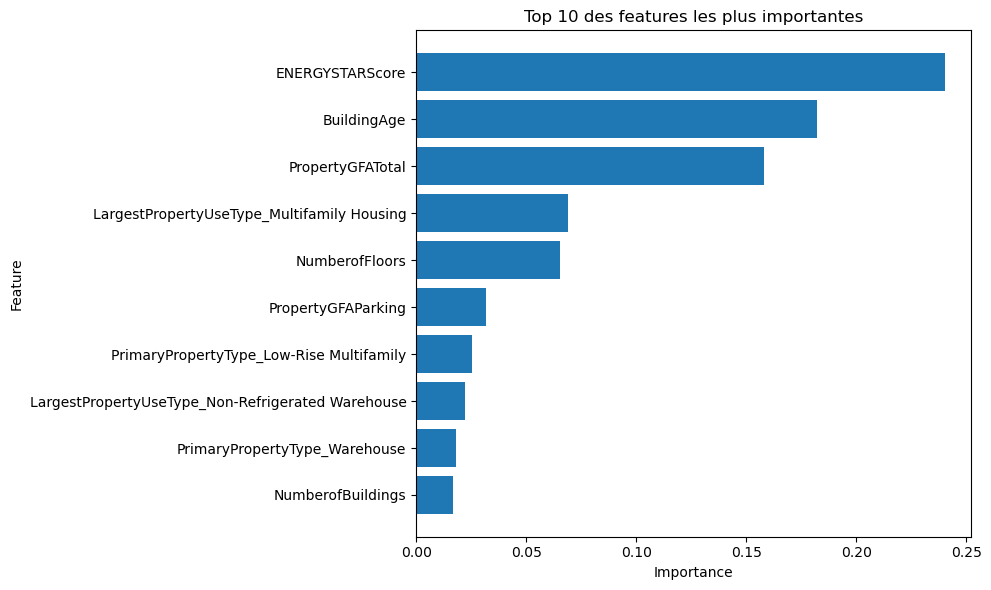

In [12]:
import matplotlib.pyplot as plt

# Sélection du Top 10
top10 = feat_imp.head(10)

# Création du graphique
plt.figure(figsize=(10, 6))
plt.barh(top10["Feature"], top10["Importance"])
plt.gca().invert_yaxis()  # Feature la plus importante en haut

# Titres et labels
plt.title("Top 10 des features les plus importantes")
plt.xlabel("Importance")
plt.ylabel("Feature")

plt.tight_layout()
plt.show()


In [13]:
import joblib

# Sauvegarde du pipeline complet (préprocesseur + modèle)
joblib.dump(best_model, "pipeline.joblib")
print("pipeline.joblib sauvegardé ")


pipeline.joblib sauvegardé 


##  Sauvegarde du pipeline optimisé

**Objectif** : enregistrer le pipeline complet (prétraitement + modèle Random Forest optimisé) afin de le réutiliser pour l’inférence ou le déploiement.

---

### Contenu du pipeline sauvegardé :
- **Prétraitement** :
  - Imputation des valeurs manquantes
  - Standardisation des variables numériques
  - Encodage One-Hot des variables catégorielles
- **Modèle** :
  - `RandomForestRegressor` avec les meilleurs hyperparamètres trouvés via `GridSearchCV`

---

### Fichier généré :
```python
pipeline.joblib


In [14]:
pipeline = joblib.load("pipeline.joblib")
preprocess = pipeline.named_steps["preprocess"]

for name, _, cols in preprocess.transformers_:
    print(name, ":", cols)

num : ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'ENERGYSTARScore', 'BuildingAge']
cat : ['PrimaryPropertyType', 'LargestPropertyUseType']
remainder : [7]


In [15]:
X_clean.columns.tolist()

['PrimaryPropertyType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'LargestPropertyUseType',
 'ENERGYSTARScore',
 'DefaultData',
 'BuildingAge']

In [16]:
import pandas as pd

test_input = pd.DataFrame([{
    "PrimaryPropertyType": "NonResidential",
    "NumberofBuildings": 1,
    "NumberofFloors": 5,
    "PropertyGFATotal": 10000,
    "PropertyGFAParking": 2000,
    "LargestPropertyUseType": "Office",
    "ENERGYSTARScore": 75,
    "DefaultData": 0,
    "BuildingAge": 30
}])

pred = pipeline.predict(test_input)
print("Prédiction SiteEUIWN(kBtu/sf) :", float(pred[0]))


Prédiction SiteEUIWN(kBtu/sf) : 57.11192116230512



 Vérification de la distribution de y_train 
Taille : 2495
Min : 0.0
Max : 116.5
Moyenne : 44.51891781347535
Médiane : 38.40000153
Écart-type : 22.83288126340155


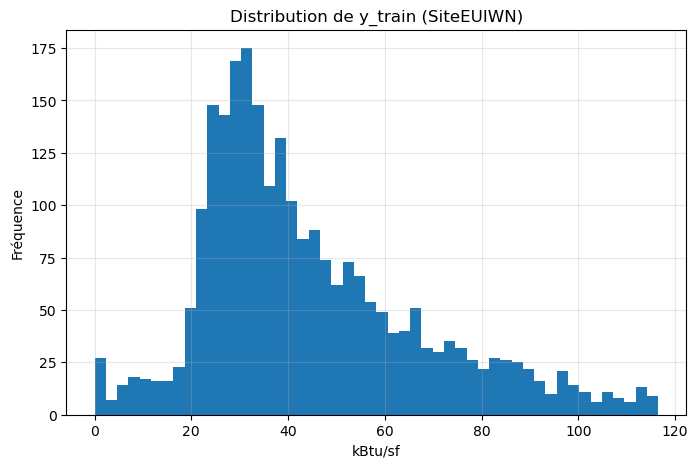

In [17]:
# Vérification complète de y_train

print("\n Vérification de la distribution de y_train ")

print("Taille :", len(y_train))
print("Min :", y_train.min())
print("Max :", y_train.max())
print("Moyenne :", y_train.mean())
print("Médiane :", y_train.median())
print("Écart-type :", y_train.std())

# Histogramme
plt.figure(figsize=(8,5))
plt.hist(y_train, bins=50)
plt.title("Distribution de y_train (SiteEUIWN)")
plt.xlabel("kBtu/sf")
plt.ylabel("Fréquence")
plt.grid(alpha=0.3)
plt.show()


In [18]:
X_train.columns.tolist()

['PrimaryPropertyType',
 'NumberofBuildings',
 'NumberofFloors',
 'PropertyGFATotal',
 'PropertyGFAParking',
 'LargestPropertyUseType',
 'ENERGYSTARScore',
 'DefaultData',
 'BuildingAge']

In [19]:
pipeline.named_steps["preprocess"].get_feature_names_out()



array(['num__NumberofBuildings', 'num__NumberofFloors',
       'num__PropertyGFATotal', 'num__PropertyGFAParking',
       'num__ENERGYSTARScore', 'num__BuildingAge',
       'cat__PrimaryPropertyType_Distribution Center',
       'cat__PrimaryPropertyType_High-Rise Multifamily',
       'cat__PrimaryPropertyType_Hospital',
       'cat__PrimaryPropertyType_Hotel',
       'cat__PrimaryPropertyType_K-12 School',
       'cat__PrimaryPropertyType_Laboratory',
       'cat__PrimaryPropertyType_Large Office',
       'cat__PrimaryPropertyType_Low-Rise Multifamily',
       'cat__PrimaryPropertyType_Medical Office',
       'cat__PrimaryPropertyType_Mid-Rise Multifamily',
       'cat__PrimaryPropertyType_Mixed Use Property',
       'cat__PrimaryPropertyType_Office',
       'cat__PrimaryPropertyType_Other',
       'cat__PrimaryPropertyType_Refrigerated Warehouse',
       'cat__PrimaryPropertyType_Residence Hall',
       'cat__PrimaryPropertyType_Restaurant',
       'cat__PrimaryPropertyType_Retail Sto

In [20]:
print("Nombre de colonnes dans X_train :", len(X_train.columns))

Nombre de colonnes dans X_train : 9


In [21]:
# Liste des colonnes
print("Liste des colonnes de X_train :")
print(X_train.columns.tolist())

Liste des colonnes de X_train :
['PrimaryPropertyType', 'NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal', 'PropertyGFAParking', 'LargestPropertyUseType', 'ENERGYSTARScore', 'DefaultData', 'BuildingAge']


In [22]:
# Aperçu des prem# Aperçu des premières lignes
X_train.head()

,PrimaryPropertyType,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,LargestPropertyUseType,ENERGYSTARScore,DefaultData,BuildingAge
272,Warehouse,1.0,1,106000,0,Non-Refrigerated Warehouse,93.0,False,53
521,K-12 School,1.0,1,52924,0,K-12 School,NaN,False,28
522,Warehouse,1.0,2,123000,0,Non-Refrigerated Warehouse,47.0,False,50
1991,Low-Rise Multifamily,1.0,3,45552,0,Multifamily Housing,50.0,False,92
1644,Low-Rise Multifamily,1.0,3,72671,0,Multifamily Housing,46.0,False,41


In [23]:
import pandas as pd

test_input = pd.DataFrame([{
    "PrimaryPropertyType": "Hotel",
    "NumberofBuildings": 1,
    "NumberofFloors": 5,
    "PropertyGFATotal": 10000,
    "PropertyGFAParking": 2000,
    "LargestPropertyUseType": "Office",
    "ENERGYSTARScore": 75,
    "DefaultData": 0,
    "BuildingAge": 30
}])

pipeline.predict(test_input)


array([56.85652751])